**Project - Stroke prediction**  <br>
**Author**: Arantxa Ortega <br>
**Date**: 31-03-2025 <br>

## Introduction

Stroke is the second leading cause of death worldwide, accounting for approximately 11% of total deaths, according to the World Health Organization (WHO). Early prediction of stroke risk can play a crucial role in preventive healthcare, allowing for timely interventions and reducing mortality rates.<br />

By building a Machine Learning (ML) model, we can identify individuals at potential risk of suffering a stroke, enabling timely interventions. Additionally, these insights can help pinpoint modifiable risk factors, contributing to preventive medicine strategies.

In this study, we analyze a dataset containing patient demographic information, medical history, and lifestyle factors to predict the likelihood of stroke occurrence. Given the demographic data, including attributes such as "work type" and "ever married," individuals under the age of 18 were not included in the analysis. This ensures our analysis focuses exclusively on the adult population.

The proposed approach involves:


### Core Components of the Analysis:
-**Exploratory Data Analysis (EDA)**: Understanding the data distribution, identifying missing values, and uncovering patterns that may influence stroke risk. <br />

-**Model Selection**: Comparing various machine learning models to determine the most effective approach for stroke prediction. <br />

-**Handling Data Imbalance**: Implementing techniques such as oversampling, undersampling, to address the imbalance for stroke occurrences. <br />

-**Performance Evaluation**: Assessing model accuracy, precision, recall, F1-score, and AUC-ROC to ensure reliable predictions. <br />

-**Results and Conclusion**: Interpreting findings and discussing their implications for stroke risk assessment. <br />


In [1]:
import os
import pandas as pd
import warnings
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import xgboost as xgb
import catboost as cb
from plotly.subplots import make_subplots
from scipy.stats import chi2_contingency
from plotly.subplots import make_subplots
from scipy.stats import norm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from utils import preprocess_and_resample, hyperparameter_tuning, evaluate_model
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

## Exploratory data analysis

### Load the data and visualize the data

In [2]:
file = 'healthcare-dataset-stroke-data.csv'
file_folder = 'data'
db_path = os.getcwd()
dataset_path = os.path.join(db_path, file_folder, file)
df = pd.read_csv(dataset_path)
df = df.drop(df.columns[[0]], axis=1)
df.rename(columns={'Employment Type': 'EmploymentType'}, inplace=True)
print(f"Size of the df: {len(df)}")
main_df = df.copy()
df.head()

Size of the df: 5110


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Check column types

In [3]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### Check for empty strings

In [4]:
if (df == '').any().any():
    print("There are empty strings in the dataset.")
else:
    print("No empty strings found.")

No empty strings found.


### Check if we have duplicated values.

In [5]:
duplicates = df[df.duplicated(keep=False)]
duplicates_sorted = duplicates.groupby(
    list(df.columns)).apply(lambda x: x).reset_index(drop=True)

duplicates_sorted.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


As observed, there are not duplicate values in the data.

### Filter the database to keep only the adult population.

Given the demographic data, including attributes such as "work type" and "ever married," we will remove individuals under the age of 18. This ensures our analysis focuses exclusively on the adult population.

In [6]:
df = df.query('age >= 18')
print(f"Size of the df: {len(df)}")

Size of the df: 4254


### Check for missing values

In [7]:
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  181
smoking_status         0
stroke                 0
dtype: int64


### Check % of missing values

In [8]:
print(df.isnull().sum()/len(df)*100)

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  4.254819
smoking_status       0.000000
stroke               0.000000
dtype: float64


As we can see we have 181 missing values in the "BMI" column of our dataset, which later will be imputed.

### Description of the quantitative variables.

In [9]:
pd.options.display.float_format = '{:.2f}'.format
quantitative_df = df.select_dtypes(include=['float64'])
quantitative_df.describe()

,age,avg_glucose_level,bmi
count,4254.00,4254.00,4073.00
mean,50.20,108.51,30.43
std,17.83,47.77,7.24
min,18.00,55.12,11.30
25%,36.00,77.48,25.40
50%,50.50,92.47,29.20
75%,64.00,116.14,34.20
max,82.00,271.74,92.00


* Age: The population has a wide age range (18 – 82 years) with a median of 50 years. <br />

* Average Glucose Levels: The average is 108.51 mg/dL, with some individuals showing very high levels (up to 271.74 mg/dL), possibly indicating diabetes risks. <br />

* BMI: The average BMI is 30.43, which means that a significant portion of individuals are in the obese (BMI > 30). <br />


### Visualization of the quantitative features.

In [10]:
color_map = {
    'bmi': 'cornflowerblue',
    'avg_glucose_level': 'royalblue',
    'age': 'dodgerblue'
}

fig = make_subplots(rows=1, cols=3)


fig.add_trace(
    go.Box(y=df['avg_glucose_level'], name='Average glucose level',
           marker=dict(color=color_map['avg_glucose_level'])),
    row=1, col=1
)


fig.add_trace(
    go.Box(y=df['bmi'], name='Body mass index',
           marker=dict(color=color_map['bmi'])),
    row=1, col=2
)


fig.add_trace(
    go.Box(y=df['age'], name='Age',  marker=dict(color=color_map['age'])),
    row=1, col=3
)


fig.update_layout(
    title={'text': 'Quantitative features', 'x': 0.5,
           'font': {'size': 20, 'family': 'Arial Black', 'weight': 'bold'}},
    showlegend=False,
    width=1300,
    height=500,
)

fig.show()

1. **Average Glucose Level:**
- The median glucose level is slightly above 90.
- The interquartile range (IQR) is relatively compact, suggesting that most values fall within a certain range.
- There are numerous outliers above 175, indicating that some individuals have significantly higher glucose levels.

2. **Body Mass Index (BMI):**
- The median BMI is around 30, which falls within the obese category.
- The IQR is narrow, but there are many high-value outliers, suggesting that some individuals have exceptionally high BMI values.
- Extreme values are also found around 70.

3. **Age:**
- The median age is 50 years.
- The distribution is more balanced and no observable outliers.
- Age has a relatively normal spread, indicating that the dataset covers a wide range of ages without extreme deviations.


4. **Decision about extreme values:**
- Glucose levels and BMI show extreme outliers, which might suggest a subset of individuals with metabolic disorders or health conditions.
- Since high glucose values are medically relevant, they should not be removed, as they provide important information about potential diabetes cases or glucose regulation issues.
- In Body Mass Index values above 70 are highly unusual and likely result from measurement errors, data entry mistakes, or extreme cases that do not represent the general population. Therefore, we will proceed to delete them.

### Distribution of a quantitative feature by stroke outcome

In [11]:
fig1 = px.violin(df, y="age", x="stroke", box=True, points="all", color="stroke",
                 color_discrete_map={0: "royalblue", 1: "firebrick"},
                 labels={"age": "Age", "stroke": "Stroke"})


fig1.update_xaxes(tickvals=[0, 1], ticktext=["No", "Yes"])
fig1.update_traces(showlegend=False)
fig1.show()

fig2 = px.violin(df, y="avg_glucose_level", x="stroke", box=True, points="all", color="stroke",
                 color_discrete_map={0: "royalblue", 1: "firebrick"},
                 labels={"avg_glucose_level": "Average glucose ", "stroke": "Stroke"})


fig2.update_xaxes(tickvals=[0, 1], ticktext=["No", "Yes"])
fig2.update_traces(showlegend=False)
fig2.show()

fig3 = px.violin(df, y="bmi", x="stroke", box=True, points="all", color="stroke",
                 color_discrete_map={0: "royalblue", 1: "firebrick"},
                 labels={"bmi": "Body mass index", "stroke": "Stroke"})

fig3.update_xaxes(tickvals=[0, 1], ticktext=["No", "Yes"])
fig3.update_traces(showlegend=False)
fig3.show()

- People who have had a stroke (right, red) tend to be older compared to those who haven't.

- The median age for stroke patients appears to be around 70, while for non-stroke individuals, it’s closer to 50.

- Most people without a stroke have lower and more consistent glucose levels, centered around 90–110.

- The distribution is more concentrated and narrow, with fewer extreme outliers.

- The median BMI for both stroke and non-stroke groups is roughly in the 30 range, suggesting that obesity is common in both.

- The stroke group has a more symmetrical and concentrated distribution with fewer extreme outliers.

- There’s a wider spread in BMI among non-stroke individuals, with more very low and very high BMI values.



#### Deletion of outliers of the BMI value

In [12]:
df = df.loc[(df['bmi'] <= 70) | (df['bmi'].isna())]

#### Total Individuals Categorized by Disease Status.

In [13]:
df[["stroke", "hypertension", "heart_disease"]] = df[[
    "stroke", "hypertension", "heart_disease"]].astype(str)

custom_colors = {
    "0": "royalblue",
    "1": "firebrick",
}

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=("Stroke Status", "Hypertension Status",
                    "Heart Disease Status")
)

fig1 = px.histogram(
    df,
    x="stroke",
    color="stroke",
    color_discrete_map=custom_colors,
    text_auto=True
)

fig2 = px.histogram(
    df,
    x="heart_disease",
    color="heart_disease",
    color_discrete_map=custom_colors,
    text_auto=True
)

fig3 = px.histogram(
    df,
    x="hypertension",
    color="hypertension",
    color_discrete_map=custom_colors,
    text_auto=True
)

for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

for trace in fig3.data:
    fig.add_trace(trace, row=1, col=3)


fig.update_layout(
    title={'text': 'Total Individuals Categorized by Disease Status', 'x': 0.5,
           'font': {'size': 20, 'family': 'Arial Black', 'weight': 'bold'}},
    showlegend=False,
    width=1300,
    height=500,
    bargap=0.2,
    bargroupgap=0
)

fig.update_xaxes(
    tickfont=dict(family="Arial", size=12, color="black", weight="bold"),
    categoryorder='category ascending',
    tickvals=["0", "1"],
    ticktext=["No", "Yes"],
    tickangle=-45,
)

fig.update_yaxes(
    title_text="<b>Total Count</b>",
    tickfont=dict(family="Arial", size=12, color="black"),
    range=[0, 5500],
    row=1, col=1
)


fig.show()

1. **Stroke Status:**

- The majority of individuals (4,004) do not have a history of stroke.

- A significantly smaller proportion (247 individuals) have experienced a stroke.

- As observed, our class to be predicted is high imbalanced, which will need to be considered for the further analysis.

2. **Hypertension Status:**

- Most individuals (3,976) do not have hypertension.

- A small fraction (275 individuals) have been diagnosed with hypertension.

3. **Heart Disease Status:**

- 3,756 individuals do not have heart disease.

- 495 individuals have been diagnosed with heart disease, which is noticeably higher than the stroke and hypertension groups.


#### Total individuals by gender in the cohort of study

In [14]:
df = df[df['gender'] != 'Other']

custom_colors_gender = {
    "Female": "royalblue",
    "Male": "firebrick",
}

fig3 = px.pie(df,

              names="gender",
              hole=0.3,
              color="gender",
              color_discrete_map=custom_colors_gender,
              title='Total individuals by gender (%)')


fig3.update_layout(
    title={'x': 0.5, 'font': {'size': 20,
                              'family': 'Arial Black', 'weight': 'bold'}},
    width=600, height=600
)


fig3.show()

In this study cohort, females represent the 60.6% of the population, while males represen 39.4%.


In [15]:
df_counts = df.groupby(
    ["stroke", "heart_disease"]
).size().reset_index(name="Count")

fig6 = px.bar(
    df_counts,
    x="heart_disease",
    y="Count",
    color="stroke",
    color_discrete_map=custom_colors,
    title="Individuals with heart disease by stroke status",
    barmode="group",
    text_auto=True
)

fig6.update_yaxes(title_text="<b>Total</b>")

fig6.update_xaxes(title_text="<b>Heart disease</b>")

fig6.update_layout(
    title={
        'x': 0.5,
        'font': {
            'size': 20,
            'family': 'Arial Black',
            'weight': 'bold'
        }
    }
)

fig6.update_layout(width=600, height=600)
fig6.show()

- The overall number of individuals without heart disease is significantly higher than those with heart disease.

- A higher proportion of individuals with a history of stroke also have heart disease, indicating a potential correlation between stroke and heart disease.

- The majority of individuals who have not had a stroke also do not have heart disease, which suggests that stroke may be a contributing factor to heart disease or vice versa.

In [16]:
df_counts = df.groupby(
    ["stroke", "hypertension"]
).size().reset_index(name="Count")

fig6 = px.bar(
    df_counts,
    x="hypertension",
    y="Count",
    color="stroke",
    color_discrete_map=custom_colors,
    title="Individuals with hypertension by stroke status",
    barmode="group",
    text_auto=True
)

fig6.update_yaxes(title_text="<b>Total</b>")

fig6.update_xaxes(title_text="<b>Hypertension</b>")

fig6.update_layout(
    title={
        'x': 0.5,
        'font': {
            'size': 20,
            'family': 'Arial Black',
            'weight': 'bold'
        }
    }
)

fig6.update_layout(width=600, height=600)
fig6.show()

- While the majority of individuals do not have hypertension, the proportion of strokes is higher among those who do.

- This suggests a potential link between hypertension and stroke risk, reinforcing the importance of managing blood pressure for stroke prevention.

## Statistical inference

Do individuals with a history of heart disease have a higher likelihood of experiencing a stroke? <br />
* H₀: There is no association between heart disease and the likelihood of having a stroke. <br />
* H₁: Individuals with heart disease have a higher probability of experiencing a stroke. <br />

### Statistical Tests

We will conduct a statistical hypothesis test to examine whether there is a significant if the individuals with heart disease are likely to suffer a stroke and those who did not. Chi-Square Test of Independence. This test checks whether there is an association between the two binary variables.

In [17]:
contingency = pd.crosstab(df['heart_disease'], df['stroke'])

chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:\n", expected)

Chi-square statistic: 66.14796866993518
p-value: 4.183105395000163e-16
Degrees of freedom: 1
Expected frequencies:
 [[3743.98235294  231.01764706]
 [ 259.01764706   15.98235294]]


* Since p < 0.05, we reject the null hypothesis. <br />
* This means there is a statistically significant association between heart disease and stroke.  <br />
* The high Chi-square statistic suggests this relationship is very strong.  <br />

### Calculate confidence intervals

In [18]:
n1, x1 = 3743, 231
n2, x2 = 259, 15

p1 = x1 / n1
p2 = x2 / n2
diff = p1 - p2

se = np.sqrt((p1 * (1 - p1)) / n1 + (p2 * (1 - p2)) / n2)

z = norm.ppf(0.975)
lower = diff - z * se
upper = diff + z * se

print(f"Difference in Proportions: {diff:.4f}")
print(f"Standard Error: {se:.4f}")
print(f"95% Confidence Interval: ({lower:.4f}, {upper:.4f})")

Difference in Proportions: 0.0038
Standard Error: 0.0150
95% Confidence Interval: (-0.0257, 0.0333)


- This means that the difference in stroke rates between individuals with and without heart disease is 0.17%, which is very small.

- The smaller standard error indicates a more precise estimate.

- The confidence interval includes 0, which means the difference in proportions is not statistically significant, suggesting that there is no statistically significant difference between the two proportions at the 5% significance level.

- Despite the chi-square test showing a significant relationship, the confidence interval suggests the magnitude of the difference is very small and there is no strong evidence that the two proportions are different. 

## Feature Engineering

### Visualization of BMI feature

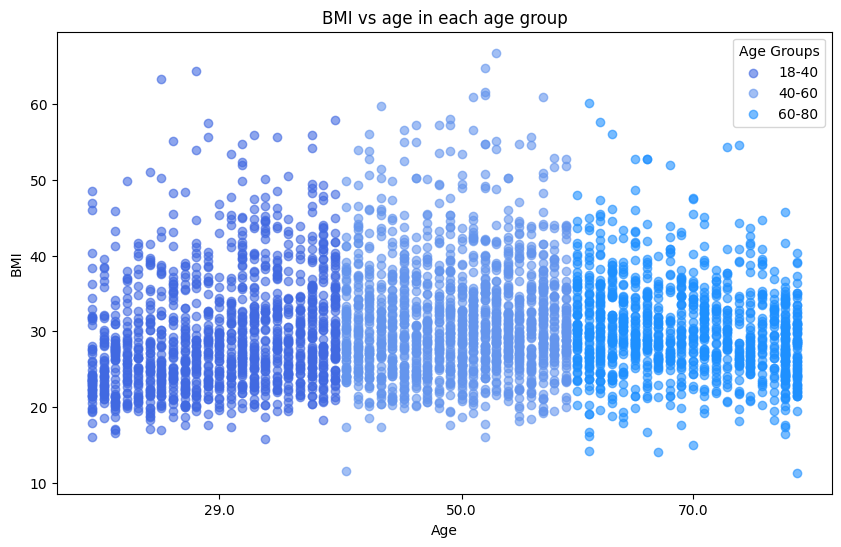

In [19]:
colors = ['royalblue', 'cornflowerblue', 'dodgerblue', 'blue']
bins = [18, 40, 60, 80]

labels = ['18-40', '40-60', '60-80']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

bin_centers = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]

plt.figure(figsize=(10, 6))

for i, label in enumerate(labels):
    subset = df[df['age_group'] == label]
    plt.scatter(subset['age'], subset['bmi'],
                label=label, alpha=0.6, color=colors[i])

for i, label in enumerate(labels):
    subset = df[df['age_group'] == label]
    if not subset.empty:
        plt.boxplot(subset['bmi'],
                    positions=[bin_centers[i]],
                    widths=8,
                    patch_artist=True,
                    boxprops=dict(facecolor=colors[i], alpha=0.4),
                    medianprops=dict(color='black'))

plt.xlabel('Age')
plt.ylabel('BMI')
plt.legend(title="Age Groups")
plt.title('BMI vs age in each age group')
plt.show()

- The density of points suggests BMI values are concentrated around 20-35 in all age groups.

- No strong upward or downward trend is visible, suggesting BMI does not drastically change with age, but individual variation exists.

- Given the slight variation in BMI across age groups, imputing missing values using the median for each specific age group is considered the most appropriate method.

### Imputation of BMI feature

In [20]:
bins = [18, 40, 60, 85]

labels = ['18-40', '40-60', '60-85']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)


df['bmi'] = df.groupby('age_group')['bmi'].transform(
    lambda x: x.fillna(x.median()))

df.drop(columns=['age_group'], inplace=True)

## Prediction of a stroke event based on Machine Learning models.


**Data Pre-processing and Transformation**
The *preprocess_and_resample* function is responsible for preparing the dataset for modeling by applying feature encoding, scaling, and handling data imbalance. The process involves:

1. Data Splitting:

* The dataset is split into training and testing sets using train_test_split, ensuring stratification based on the target variable.

* The training set is used for model selection and hyperparameter tuning.

* The test set serves as a holdout set to evaluate the final model’s performance.

2. Feature Transformation using ColumnTransformer:

* Categorical Features: Encoded using OrdinalEncoder.

* Numerical Features: Standardized using StandardScaler.

3. Handling Class Imbalance:

* Oversampling: Using SMOTE-NC to generate synthetic samples for the minority class.

* Undersampling: Using RandomUnderSampler to reduce the majority class size.

**Model selection & Evaluation** 

*hyperparameter_tuning* Function:

* Performs hyperparameter tuning using GridSearchCV to optimize model performance.

* Evaluates models based on tuned parameters and selects the best configuration.

**Model Deployment Strategies**

This study evaluates three different deployment approaches:

1. Without data imbalance handling

2. With oversampling (SMOTE-NC applied to training data)

3. With undersampling (RandomUnderSampler applied to training data)

**Evaluation Steps in Each Deployment**

In each model deployment:

* Best Model Selection with Hyperparameter Tuning (Using GridSearchCV)

* Model Evaluation using key metrics (accuracy, precision, recall, F1-score)

* Final Validation: The best-performing model from hyperparameter tuning is tested on the validation set.


## Model Selection and the Critical Importance of Recall

For model selection, we prioritize optimizing recall, as this is crucial for our stroke prediction dataset. Since stroke cases are significantly rarer than non-stroke cases, missing a true positive (i.e., failing to identify a high-risk patient) could have severe consequences.

By optimizing recall:

* We minimize false negatives, ensuring that as many stroke-risk patients as possible are correctly identified.

* Early intervention becomes more feasible, potentially reducing the severity or occurrence of strokes through timely medical action.

* Patient safety is prioritized over precision, as the cost of a false positive (extra medical tests) is far less critical than the cost of a false negative (a missed stroke diagnosis).

* While other metrics like F1-score provide a balanced evaluation, in this context, recall is the most important factor, as missing a stroke case can have life-threatening consequences.

## Model deployment without data imbalanced strategies

In [21]:
X_train, X_test, y_train, y_test = preprocess_and_resample(
    df, target_col="stroke",  resampling_method='None')

### Hyperparameter tuning (without data imbalance strategy)

In [22]:
random_seed = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

hyperparameter_tuning(X_train, y_train, cv, random_seed=42)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 173, number of negative: 2802
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 2975, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.058151 -> initscore=-2.784797
[LightGBM] [Info] Start training from score -2.784797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

As observed, the Support Vector Classifier achieved the highest recall at 0.14—a notably low value on the training set. Given the data imbalance, this result is expected. 

### Best model performance on the validation set (without data imbalance strategy)

In [23]:
svc_model = SVC(C=10, degree=2, gamma='scale', kernel='sigmoid')

svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)

y_true = y_test

evaluate_model(y_true, y_pred)

Evaluating the validation set with the Support Vector Classifier yielded a low recall (0.21), which we aim to optimize. This may be due to class imbalance in the cohort. Therefore, we will implement strategies to address this issue.


## Applying data imbalaced strategies (oversampling)

In [24]:
X_train, X_test, y_train, y_test = preprocess_and_resample(
    df, target_col="stroke",  resampling_method='smote')

hyperparameter_tuning(X_train, y_train, cv, random_seed=42)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 2802, number of negative: 2802
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 5604, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

As observed, the KNeighbors Classifier achieved the highest recall at 0.97—a notably high value on the training set. Therefore, we will proceed if these notable results are obtained on the validation set. 

### Best model performance on the validation set (with oversampling strategy)

In [25]:
knn_model = KNeighborsClassifier(n_neighbors=7, weights='distance')

knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

y_true = y_test

evaluate_model(y_true, y_pred)

As we can see, the KNN model achieved the best results on both the training and test sets (0.94), but it struggled on the validation set (0.34). This suggests that the model may be overfitting memorizing the training data too well while failing to generalize to new, unseen data. Given this issue, we will explore an alternative approach, specifically undersampling.

## Applying data imbalaced strategies (undersampling)

In [26]:
X_train, X_test, y_train, y_test = preprocess_and_resample(
    df, target_col="stroke",  resampling_method='undersample')

hyperparameter_tuning(X_train, y_train, cv, random_seed=42)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 173, number of negative: 173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 346, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
+---+--------------------------------+----------------------+------------+------------------------------------------------------------------------------------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   |           Best Model         

The best model performances were achieved by the Support Vector Classifier, XGBoost, and CatBoost, with a recall of 0.85, highlighting the efficiency of Boosting models. We will proceed to test XGBoost and CatBoost on the validation set, as these models provide access to feature importance. In the biomedical context, model explainability is crucial, making these models particularly valuable in this analysis.

### Best model performance on the validation set (applying undersampling strategy)

In [27]:
xgb_model = xgb.XGBClassifier(
    gamma=0,
    learning_rate=0.0001,
    max_depth=3,
    min_split_loss=25,
    n_estimators=200
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

y_true = y_test

evaluate_model(y_true, y_pred)

In [28]:
feature_importance = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:\n")
print(feature_importance_df)


Feature Importance:

                     Feature  Importance
7                scaler__age        1.00
0            encoder__gender        0.00
1      encoder__hypertension        0.00
2     encoder__heart_disease        0.00
3      encoder__ever_married        0.00
4         encoder__work_type        0.00
5    encoder__Residence_type        0.00
6    encoder__smoking_status        0.00
8  scaler__avg_glucose_level        0.00
9                scaler__bmi        0.00


As observed from the feature importance in the XGBoost model, a single feature dominates, suggesting a potential issue with overfitting.

In [29]:
cat_model = cb.CatBoostClassifier(
    depth=3,
    iterations=50,
    learning_rate=0.01,
    verbose=0)

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

y_true = y_test

evaluate_model(y_true, y_pred)

In [30]:
feature_importance = cat_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:\n")
print(feature_importance_df)


Feature Importance:

                     Feature  Importance
7                scaler__age       89.24
8  scaler__avg_glucose_level        3.50
9                scaler__bmi        2.34
1      encoder__hypertension        1.60
6    encoder__smoking_status        1.45
4         encoder__work_type        1.30
2     encoder__heart_disease        0.36
5    encoder__Residence_type        0.11
0            encoder__gender        0.10
3      encoder__ever_married        0.00


As observed from the feature importance in the Cat Boost model, age is still the most important feature (89.24), but other variables also contribute, such as glucose level, BMI, hypertension, and smoking status, giving us more reliable results. 

### Feature selection using mutual selection 

In [31]:
mi = mutual_info_classif(X_train, y_train, random_state=42)
mi_series = pd.Series(mi, index=X_train.columns)
mi_series.sort_values(ascending=False, inplace=True)
print(mi_series)

top_k = 5  
selected_features = mi_series.head(top_k).index
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

cat_model = cb.CatBoostClassifier(
    depth=3,
    iterations=50,
    learning_rate=0.01,
    verbose=0)
cat_model.fit(X_train_selected, y_train)
y_pred = cat_model.predict(X_test_selected)

y_true = y_test

evaluate_model(y_true, y_pred)

scaler__age                 0.19
encoder__smoking_status     0.04
encoder__work_type          0.03
encoder__ever_married       0.02
scaler__bmi                 0.02
encoder__heart_disease      0.02
encoder__hypertension       0.02
scaler__avg_glucose_level   0.00
encoder__gender             0.00
encoder__Residence_type     0.00
dtype: float64


We used mutual information to evaluate the relevance of each feature for stroke prediction, selecting the top 5 features based on their MI scores. These included age (0.19), smoking status (0.04), work type (0.03), ever married (0.02), and body mass index (0.02). A CatBoost classifier with previously optimized hyperparameters was then trained using these selected features. The model was evaluated on the test set, achieving notable performance, particularly with a recall of 0.85, highlighting its effectiveness in identifying potential stroke cases.

## Results and Discussion

1. **Feature Importance & Selection**  
  * Age was identified as the most influential factor in stroke prediction (89.24 in CatBoost).  
  * Other relevant features included glucose level, BMI, hypertension, and smoking status.  
  * Mutual information analysis confirmed age, smoking status, work type, marital status, and BMI as key predictors.  

2. **Model Performance**  
  * The CatBoost classifier, trained with optimized hyperparameters and top MI-selected features, achieved a recall of 0.85, making it highly effective in identifying stroke cases.  

3. **Data Imbalance Handling**  
  * SMOTE-NC improved recall but introduced synthetic data, potentially affecting generalization.  
  * Undersampling preserved real data but risked information loss by removing majority-class samples.  

4. **Deployment Strategies**  
  * Models trained without imbalance handling performed suboptimally in detecting minority-class cases.  
  * Oversampling and undersampling both impacted performance, requiring careful selection based on the use case.  

5. **Final Considerations**  
  * Feature selection and imbalance-handling techniques significantly influence predictive accuracy.  
  * The chosen strategy should balance recall and overall model reliability, depending on real-world application needs.

## Conclusions

- CatBoost with selected features performed best, achieving a recall of 0.85, making it highly effective in identifying stroke cases while maintaining strong overall performance.

- Age is the most critical predictor, with additional important features including glucose level, BMI, hypertension, and smoking status, confirming their role in stroke risk assessment.

- Handling class imbalance impacts results, with SMOTE-NC improving recall by introducing synthetic data, while undersampling maintains data integrity but risks information loss.

- Feature selection improves model efficiency, as using mutual information to select top predictors helped streamline the model while maintaining strong predictive power.

- Future Improvements: Exploring additional ensemble learning techniques, refining feature engineering, and testing alternative resampling methods could further enhance model accuracy and reliability.